In [1]:
## Try to vectorize field boundaries from a raster image

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append('../scripts/')
import historic_wall_inference as hwi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
import skimage.transform
import cv2
import pandas as pd

# 1) Probabilistic Hough Tansform

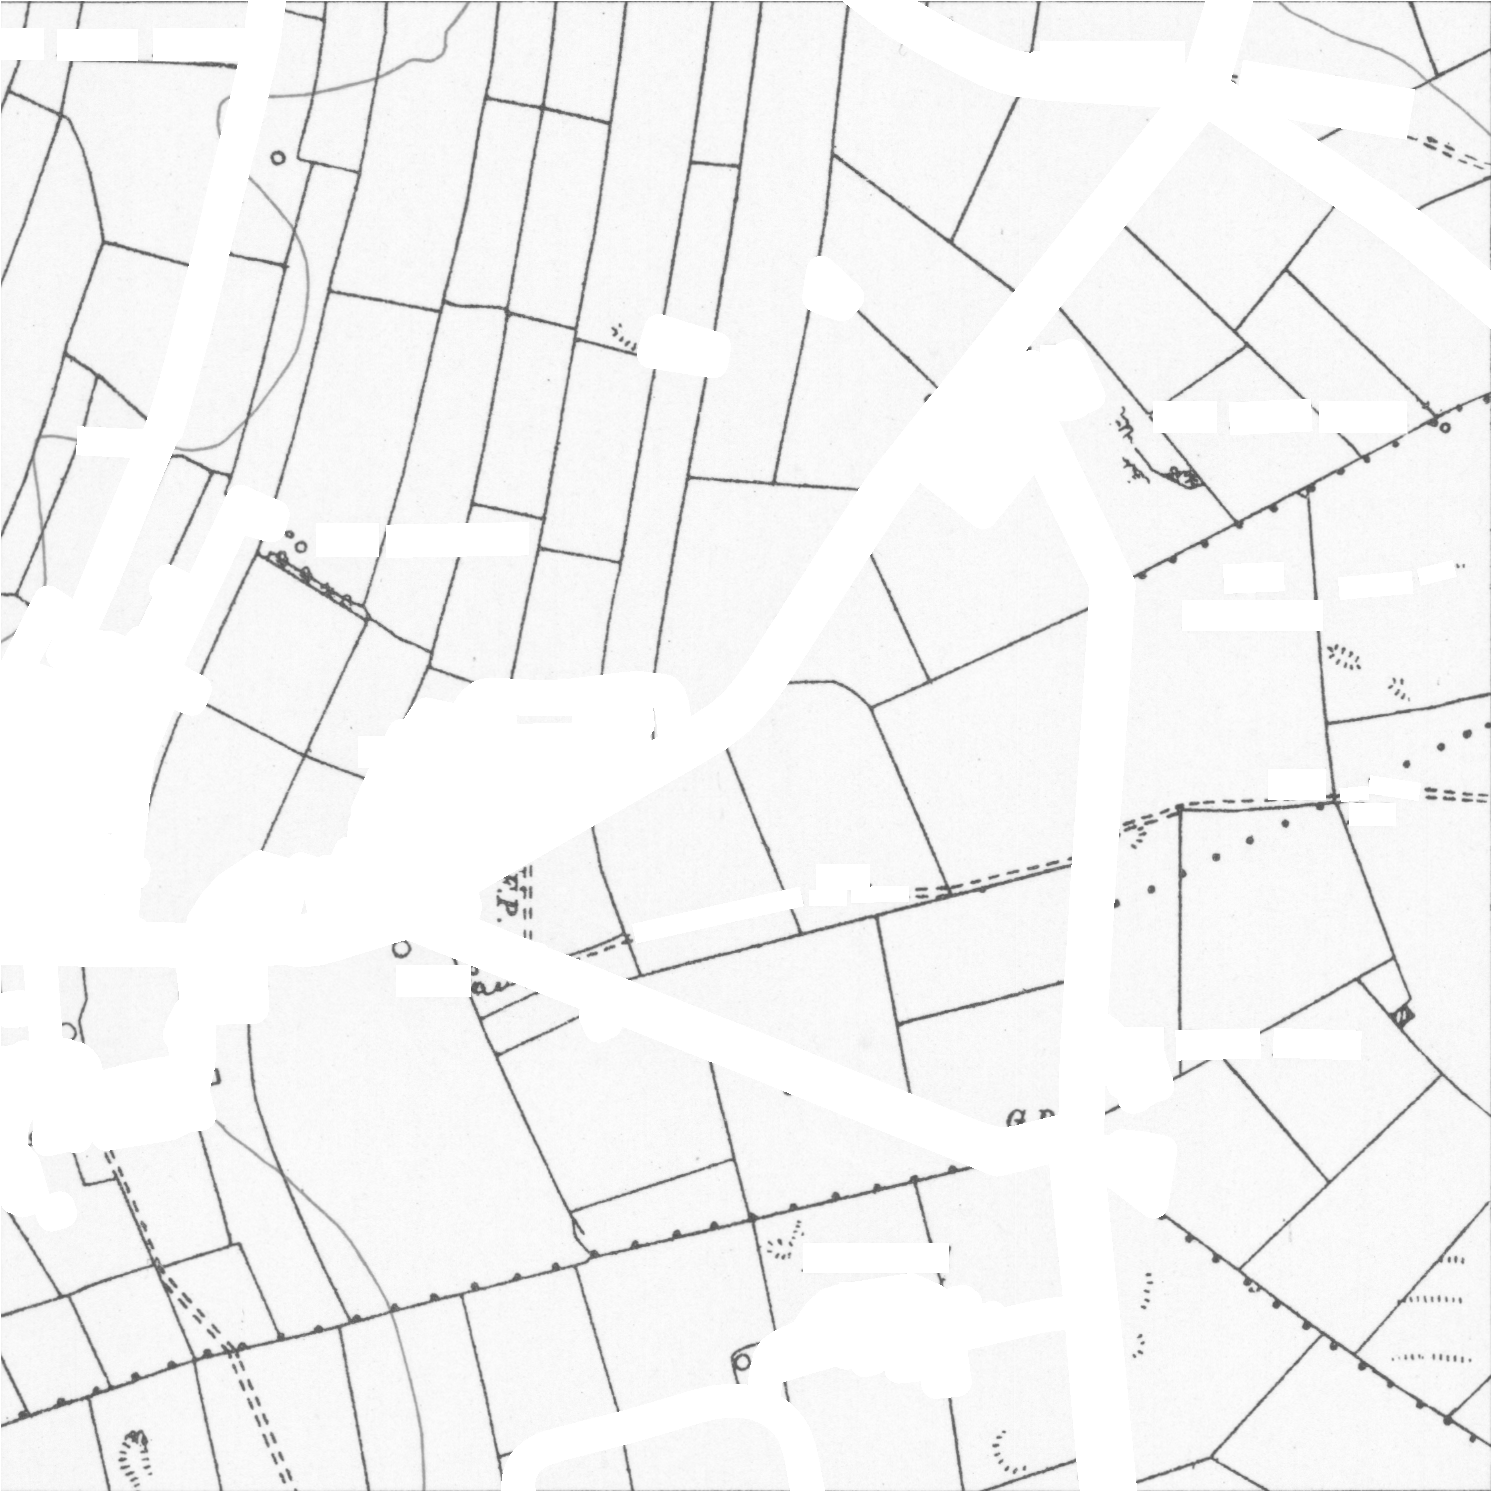

In [4]:
#im = PIL.Image.open("../content/tifs/1k_tifs/SK1468.tif")
im = PIL.Image.open("../content/tifs/masked/SK1468_combined.tif")
im = im.convert("L")
im  # visualise in jupyter notebook:

/tmp/ipykernel_5539/2149785761.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


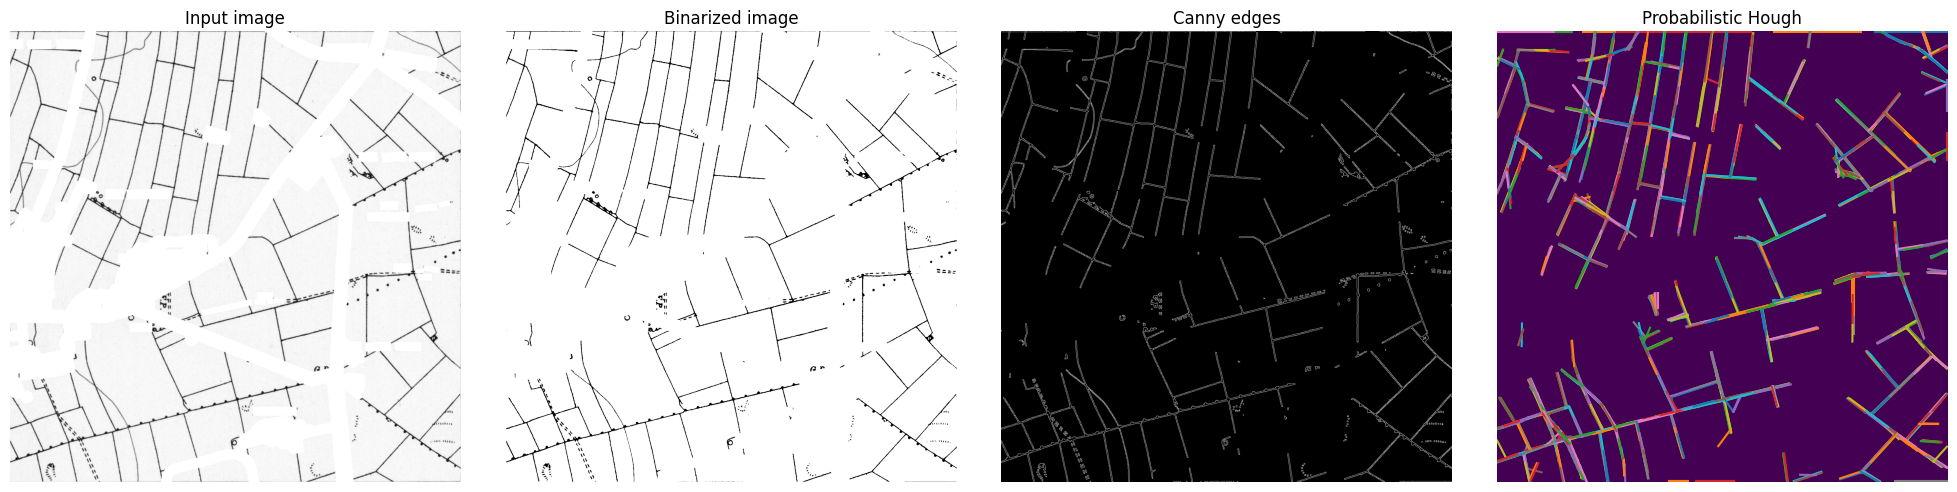

In [9]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm

# Convert the image to a numpy array
ima = np.asarray(im)

# Binarise image (assuming hwi.binarise_array() is your custom binarization function)
ima = hwi.binarise_array(ima)

# Convert the numpy array to a cv::UMat
#ima_um = cv2.UMat(ima.astype(np.uint8))

# Morphological Gradient
#kernel = np.ones((5, 5), np.uint8)
#gradient = cv2.morphologyEx(ima_um, cv2.MORPH_GRADIENT, kernel)

# Convert the cv::UMat to numpy array
#gradient_np = gradient.get()

# Canny edge detection
edges = canny(ima, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

# Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=1, line_length=50, line_gap=20)

# Display
fig, axes = plt.subplots(1, 4, figsize=(25, 25), sharex=True, sharey=True, gridspec_kw={'wspace': 0.1})
ax = axes.ravel()

ax[0].imshow(im, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(ima, cmap='Greys')
ax[1].set_title('Binarized image')

#ax[2].imshow(gradient_np, cmap='Greys')
#ax[2].set_title('Morphological Gradient')

ax[2].imshow(edges, cmap=cm.gray)
ax[2].set_title('Canny edges')

ax[3].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[3].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[3].set_xlim((0, ima.shape[1]))
ax[3].set_ylim((ima.shape[0], 0))
#ax[4].set_xlim((100, 600))
#ax[4].set_ylim((100, 600))   
ax[3].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

### Patch Test

In [35]:
# Patch test

df = pd.read_csv(r"../content/predictions/predictions_patch_df.csv")

# lets test on a single patch
im = PIL.Image.open(df.iloc[1300]['geotiff_path'])
im = im.convert("L")
im  # visualise in jupyter notebook:

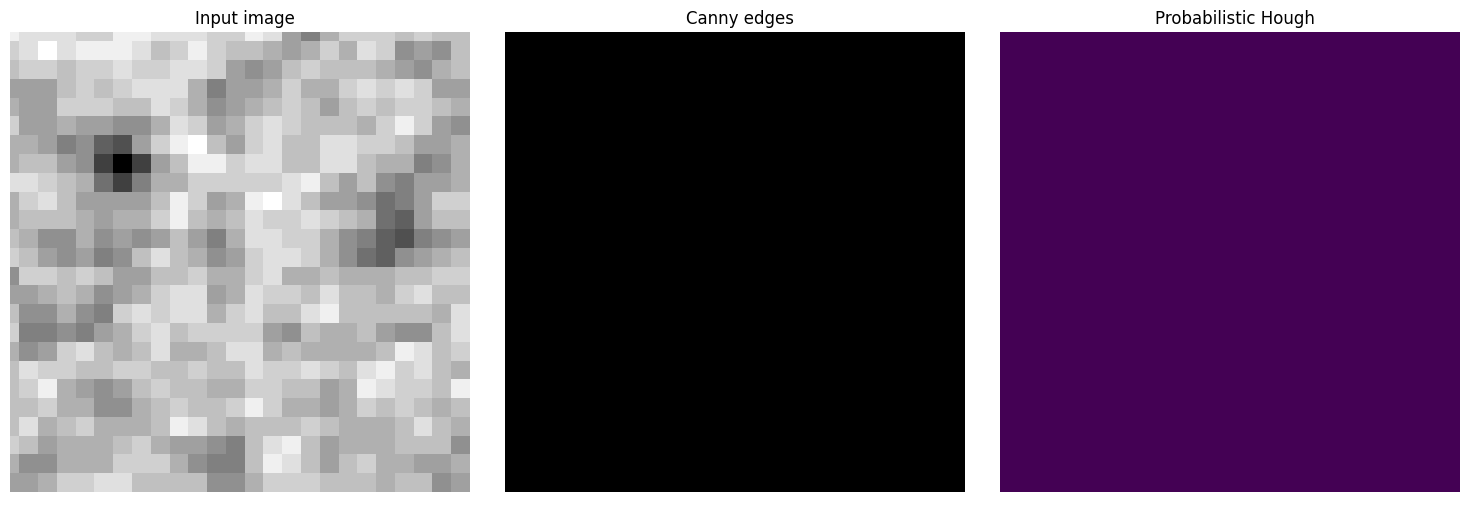

In [8]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm

im = np.asanyarray(im)

## Binarise image:
#im = hwi.binarise_array(im)

edges = canny(im, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=2, line_gap=5)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, im.shape[1]))
ax[2].set_ylim((im.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Close all OpenCV windows
cv2.destroyAllWindows()

# 2) Hough Transform

C:\Users\alexad\AppData\Local\Temp\ipykernel_15640\34272638.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


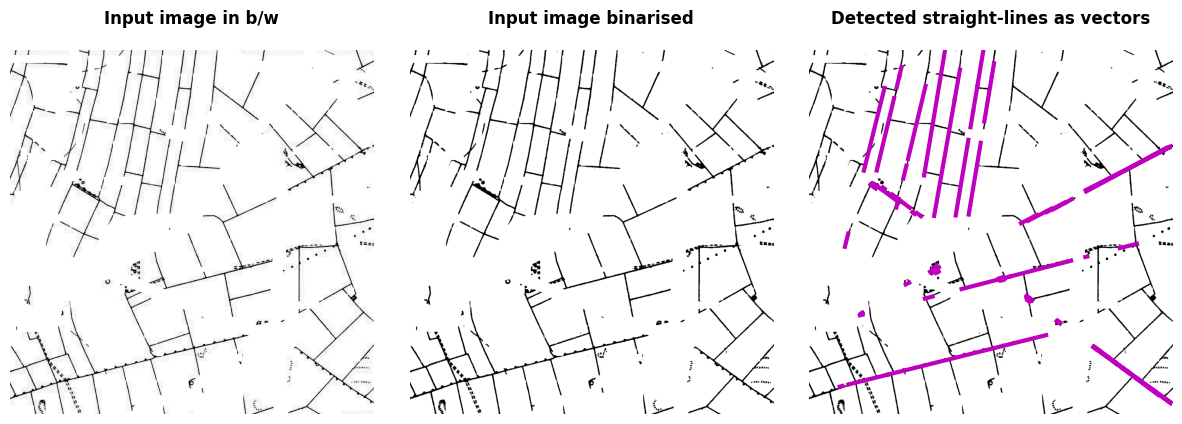

In [73]:
## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
arr = arr[5:-5 :][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()

### Patch Test

In [5]:
# lets test on a single patch
im = PIL.Image.open(df.iloc[1200]['geotiff_path'])
im = im.convert("L")
im  # visualise in jupyter notebook:

C:\Users\alexad\AppData\Local\Temp\ipykernel_23516\1008291764.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


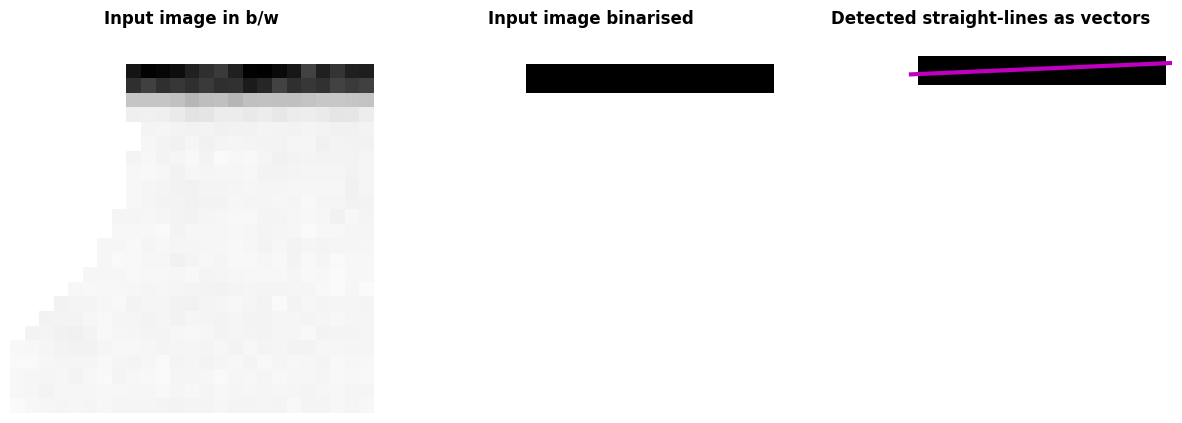

In [6]:
## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
#arr = arr[5:-5 :][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()

In [73]:
# try looping through the images

# Create an empty DataFrame to store inferred lines
df_inferred_lines_all = pd.DataFrame(columns=['x', 'y'])

# Loop through rows where label is 'wall'
for index, row in df[df['label'] == 'wall'].iterrows():
    # Load the image
    im = PIL.Image.open(row['image_path'])
    
    # Binarise image:
    arr_bin = hwi.binarise_array(arr)

    # Hough transform to detect straight lines:
    h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

    # Find start and end points of each line:
    list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)

    # Concatenate the inferred lines to df_inferred_lines_all
    df_inferred_lines_all = pd.concat([df_inferred_lines_all, df_inferred_lines], ignore_index=True)

# Print or use df_inferred_lines_all as needed
df_inferred_lines_all.head(3)

,x,y
0,"(0, 25)","(4.469601539088952, 16.934141740424742)"
1,"(0, 25)","(4.469601539088952, 16.934141740424742)"
2,"(0, 25)","(4.469601539088952, 16.934141740424742)"
